In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!mkdir -p ~/.kaggle 
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:03<00:00, 102MB/s] 
100% 346M/346M [00:03<00:00, 91.8MB/s]


In [ ]:
from zipfile import ZipFile 
file_name = "intel-image-classification.zip"

with ZipFile (file_name ,"r") as zip:
  zip.extractall()
  print ("Done")

Done


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content"))


['.config', 'seg_pred', 'seg_test', 'kaggle.json', 'seg_train', 'intel-image-classification.zip', 'sample_data']


In [ ]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder

# path
train_path = '/content/seg_train'
test_path = '/content/seg_test'
valid_path = '/content/seg_pred'


transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],
                         [0.5, 0.5, 0.5])
])



train_data = datasets.ImageFolder(train_path, transform=transforms)
test_data = datasets.ImageFolder(test_path, transform=transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=300, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=300)
len(trainloader)

47

In [ ]:
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

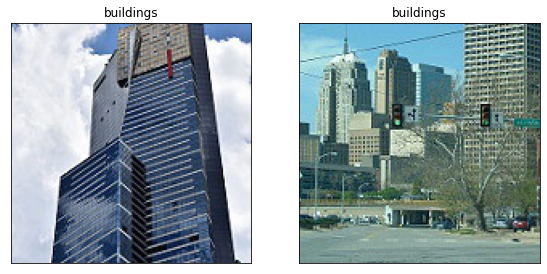

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data_iter = iter(testloader)
images, labels = data_iter.next()

fig = plt.figure(figsize=(25, 5))
for idx in range(2):
    ax = fig.add_subplot(1, 5, idx + 1, xticks=[], yticks=[])
    # unnormolaize first
    img = images[idx] / 2 + 0.5
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0)) #transpose
    ax.imshow(img, cmap='gray')
    ax.set_title(classes[labels[idx]])

In [ ]:
model = models.vgg16(pretrained=True)
model.classifier

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [ ]:
for pram in model.parameters():
    pram.requires_grad = False

In [ ]:
import torch.nn as nn

clasiifier = nn.Sequential(
  nn.Linear(in_features=25088, out_features=4096),
  nn.ReLU(),
  nn.Dropout(p=0.2),
  nn.Linear(in_features=4096, out_features=4096),
  nn.ReLU(),
  nn.Dropout(p=0.5),
  nn.Linear(in_features=4096, out_features=6),
  nn.LogSoftmax(dim=1)  
)

model.classifier = clasiifier

In [ ]:
import torch.optim as optim
import torch

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.003)
#gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
!pip install tqdm

In [ ]:
# from tqdm import tqdm

epochs = 3
steps = 0
running_loss = 0
print_every = 10
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/3.. Train loss: 0.179.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 1/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 1/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 1/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 2/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 2/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 2/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 2/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 2/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 3/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 3/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 3/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 3/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy: 1.000
Epoch 3/3.. Train loss: 0.000.. Test loss: 0.000.. Test accuracy

In [ ]:
# track test loss
classes = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

test_loss = 0.0
class_correct = list(0. for i in range(6))
class_total = list(0. for i in range(6))

with torch.no_grad():
  model.eval()
  # iterate over test data
  for data, target in testloader:
      # move tensors to GPU if CUDA is available
      data, target = data.to(device), target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the batch loss
      loss = criterion(output, target)
      # update test loss 
      test_loss += loss.item()*data.size(0)
      # convert output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # compare predictions to true label
      correct = np.squeeze(pred.eq(target.data.view_as(pred)))
      # calculate test accuracy for each object class
      for i in range(38):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

# average test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(6):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.000000

Test Accuracy of buildings: 100% (380/380)
Test Accuracy of forest: N/A (no training examples)
Test Accuracy of glacier: N/A (no training examples)
Test Accuracy of mountain: N/A (no training examples)
Test Accuracy of   sea: N/A (no training examples)
Test Accuracy of street: N/A (no training examples)

Test Accuracy (Overall): 100% (380/380)
